In [2]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")
include(CODE_ROOT * "mode_init/exactsolutions.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean_CUDA.jl")

update_ssh_by_tendency_cuda_kernel! (generic function with 1 method)

In [3]:
using BenchmarkTools
using DelimitedFiles
using Dates

In [23]:
function kelvinWaveCUDAGenerator(mpasOcean, lateralProfile)
    meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)
    meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)
    c = sqrt(mpasOcean.gravity*meanFluidThicknessH)
    rossbyRadiusR = c/meanCoriolisParameterf
    
    
    function boundaryConditionCUDA_kernel!(nEdges, normalVelocityCurrent, boundaryEdge, angleEdge, yEdge, xEdge, t)
        iEdge = (CUDA.blockIdx().x - 1) * CUDA.blockDim().x + CUDA.threadIdx().x
        if iEdge <= nEdges
            if boundaryEdge[iEdge] == 1
                normalVelocityCurrent[iEdge,:] .= CUDA.sin(angleEdge[iEdge]) * c * lateralProfile(yEdge[iEdge] + c*t) * CUDA.exp(-xEdge[iEdge]/rossbyRadiusR)
            end
        end
        return nothing
    end
    function boundaryConditionCUDA!(mpasOcean::MPAS_Ocean_CUDA, t::Float64)
        CUDA.@cuda blocks=cld(mpasOcean.nEdges, 1024) threads=1024 maxregs=64 boundaryConditionCUDA_kernel!(mpasOcean.nEdges,
                                                                                        mpasOcean.normalVelocityCurrent,
                                                                                        mpasOcean.boundaryEdge,
                                                                                        mpasOcean.angleEdge,
                                                                                        mpasOcean.yEdge,
                                                                                        mpasOcean.xEdge,
                                                                                        t)
        return nothing
    end

    return boundaryConditionCUDA!
end

kelvinWaveCUDAGenerator (generic function with 1 method)

In [83]:
function gpucpuperftest(nCellsX, nSamples=10, nSteps=10, device="CPU", showplots=false, writedata=false; nvlevels=100)
    fpath = CODE_ROOT * "output/asrock/serial$(device)_timing/coastal_kelvinwave/steps_$nSteps/resolution_$(nCellsX)x$(nCellsX)/nvlevels_$(nvlevels)/"
    fname = "$fpath$(Dates.now()).txt"
    if writedata
        mkpath(fpath)
        println("output file: $fname")
    end
    
    mpasMesh = MPAS_Ocean(CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
        "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", periodicity="NonPeriodic_x", nvlevels=nvlevels)
    mpasOcean = mpasMesh
    device_step_nv! = function(mpasOcean)
        calculate_normal_velocity_tendency!(mpasOcean)
        update_normal_velocity_by_tendency!(mpasOcean)
    end
    device_step_ssh! = function(mpasOcean)
        calculate_ssh_tendency!(mpasOcean)
        update_ssh_by_tendency!(mpasOcean)
    end

    @inline function lateralProfile(y)
        return 1e-3 * exp( - (y-3e6)^2 / 5e5^2 )
    end
    
    kelvinWaveExactNormalVelocity, kelvinWaveExactSSH, kelvinWaveExactSolution!, device_boundary_condition! = kelvinWaveGenerator(mpasOcean, lateralProfile)
    
    
    
    exacttime = 0.0
    kelvinWaveExactSolution!(mpasOcean, exacttime)
    
    if showplots
        fig, ax, _ = heatMapMesh(mpasMesh, mpasOcean.sshCurrent)
        ax.set_title("Initial Sea Surface Height")
        display(fig)
    end
    
    if "GPU" == device
        mpasOcean = MPAS_Ocean_CUDA(mpasOcean)
        device_boundary_condition! = kelvinWaveCUDAGenerator(mpasOcean, lateralProfile)
        device_step_nv! = function(mpasOcean)
            calculate_normal_velocity_tendency_cuda!(mpasOcean)
            update_normal_velocity_by_tendency_cuda!(mpasOcean)
        end
        device_step_ssh! = function(mpasOcean)
            calculate_ssh_tendency_cuda!(mpasOcean)
            update_ssh_by_tendency_cuda!(mpasOcean)
        end
    end
    
    sampletimes = zeros(Float64, nSamples)
    
    for s in 1:nSamples
        sampletimes[s] += @elapsed begin for j in 1:nSteps
                device_step_nv!(mpasOcean)
                device_boundary_condition!(mpasOcean, exacttime)
                device_step_ssh!(mpasOcean)
                exacttime += mpasOcean.dt
            end
        end
    end
    
    
    println("calculating error")
    exactSSH = zeros(Float64, mpasOcean.nCells)
    for iCell in 1:mpasOcean.nCells
        exactSSH[iCell] = kelvinWaveExactSSH(mpasMesh, iCell, exacttime)
    end
    
    error =  sum( ( Array(mpasOcean.sshCurrent) .- exactSSH ) .^ 2 )
    
    if showplots
        fig, ax, _ = heatMapMesh(mpasMesh, Array(mpasOcean.sshCurrent))
        ax.set_title("Final Numerical Sea Surface Height")
        display(fig)
        
        fig, ax, _ = heatMapMesh(mpasMesh, exactSSH)
        ax.set_title("Final Exact Sea Surface Height")
        display(fig)
    end
    
    if writedata
        open(fname, "w") do io
            writedlm(io, sampletimes)
        end
    end
    
    return sampletimes, error, mpasOcean, mpasMesh
end

gpucpuperftest (generic function with 6 methods)

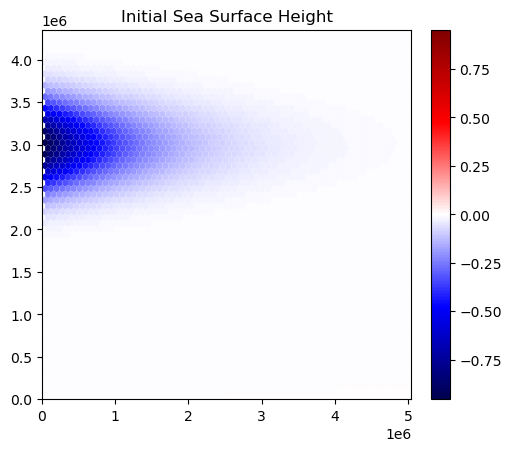

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_20/resolution_64x64/nvlevels_100/2022-09-07T16:27:56.755.txt


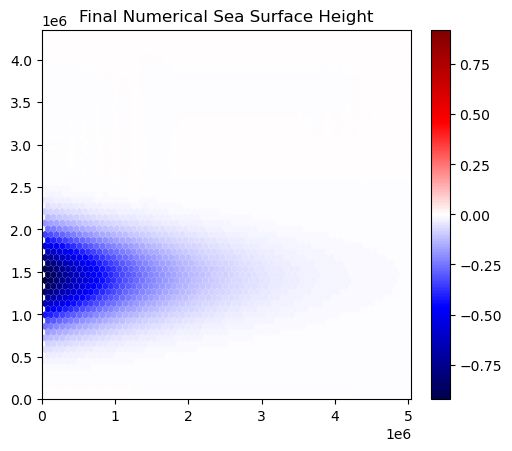

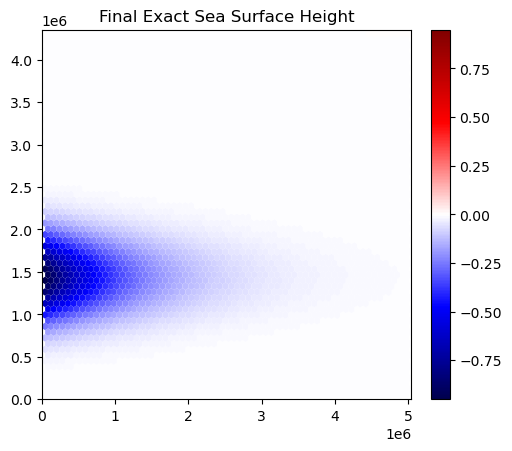

calculating error
execution time: [0.000245039, 0.000217845, 0.000187222, 0.000171114, 0.000171586, 0.000204784, 0.000167318, 0.000166422, 0.000166071, 0.000168319]
error: 0.008421515424139738


In [87]:
nCellsX = 64
wcgpu, errgpu, mpasOceanCuda, mpasMesh = gpucpuperftest(nCellsX, 10, 20, "GPU", true, true, nvlevels=100)
println("execution time: $wcgpu")
println("error: $errgpu")

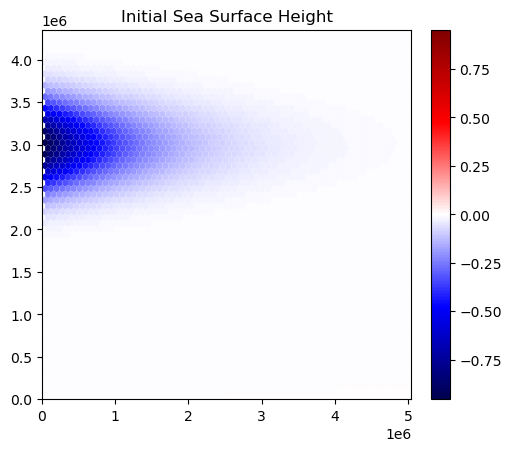

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_20/resolution_64x64/nvlevels_100/2022-09-07T16:27:58.177.txt


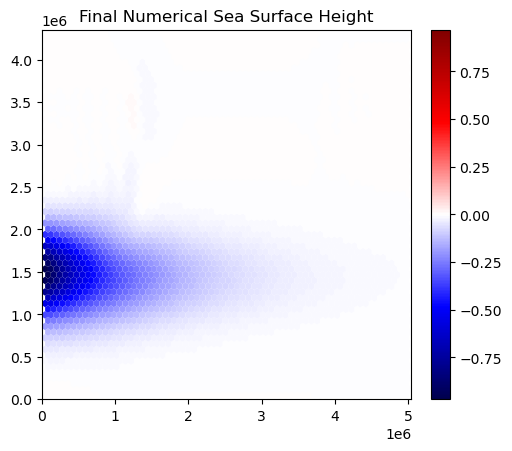

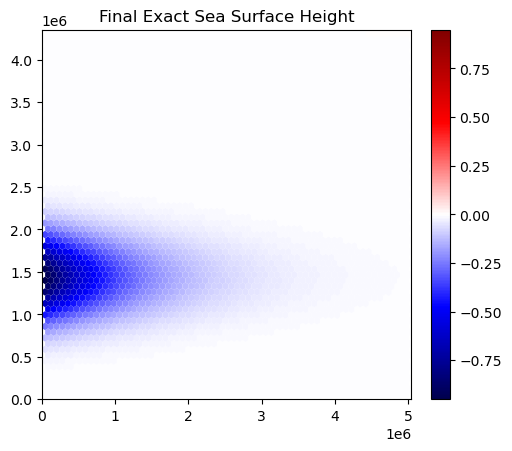

calculating error
execution time: [2.996161833, 2.911170335, 3.037205519, 2.896653671, 2.906291862, 2.805456136, 2.785886156, 2.911055654, 3.119316012, 2.822508824]
error: 0.3856716069032127


In [88]:
nCellsX = 64
wccpu, errcpu, mpasOceanCuda, mpasMesh = gpucpuperftest(nCellsX, 10, 20, "CPU", true, true, nvlevels=100)
println("execution time: $wccpu")
println("error: $errcpu")


In [90]:
avgcpu = sum(wccpu)/length(wccpu)
avggpu = sum(wcgpu)/length(wcgpu)
avgcpu, avggpu, " speedup: ", avgcpu/avggpu

(2.9191706002, 0.000186572, " speedup: ", 15646.348863709454)

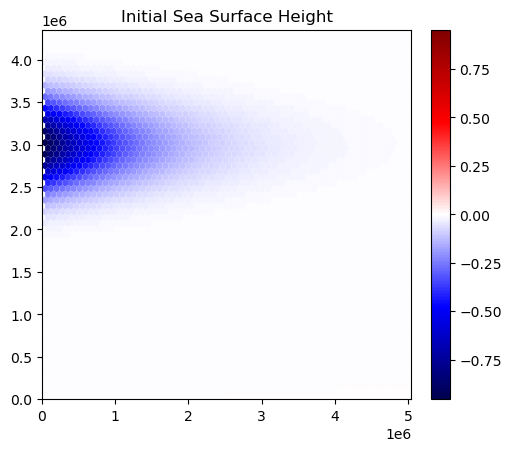

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_20/resolution_64x64/nvlevels_100/2022-09-07T16:26:48.816.txt
calculating error


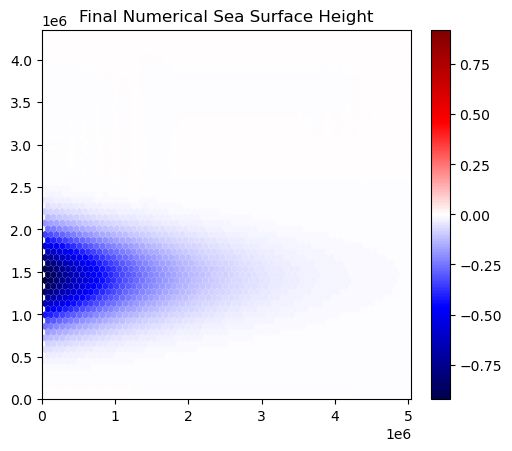

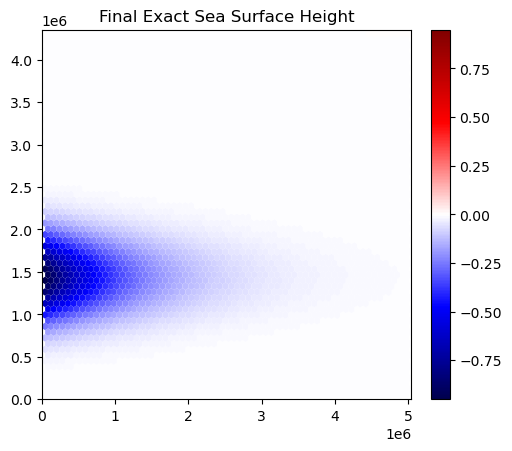

execution time: [0.894077582, 0.000168608, 0.000167301, 0.000167289, 0.000167814, 0.000167831, 0.000167271, 0.000168613, 0.000173691, 0.000167365]
error: 0.008421515424139738


In [84]:
nCellsX = 64
wcgpu, errgpu, mpasOceanCuda, mpasMesh = gpucpuperftest(nCellsX, 10, 20, "GPU", true, true, nvlevels=2)
println("execution time: $wcgpu")
println("error: $errgpu")

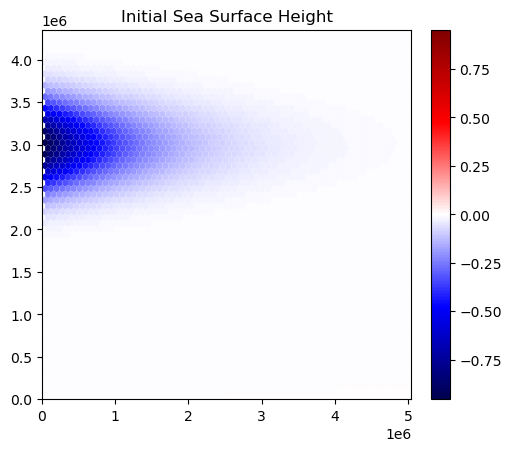

In [ ]:
nCellsX = 64
wccpu, errcpu, mpasOceanCuda, mpasMesh = gpucpuperftest(nCellsX, 10, 20, "CPU", true, true, nvlevels=2)
println("execution time: $wccpu")
println("error: $errcpu")

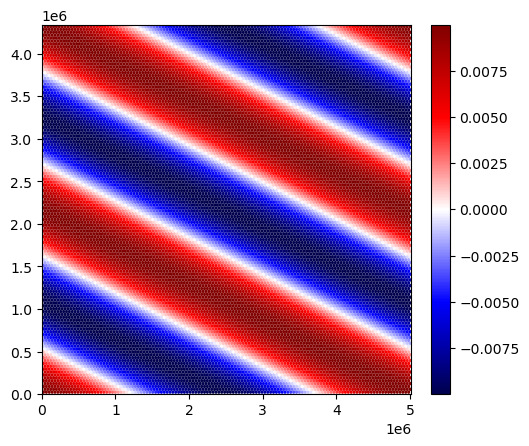

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_10/resolution_128x128/nvlevels_100/2022-09-07T14:43:45.370.txt
calculating error


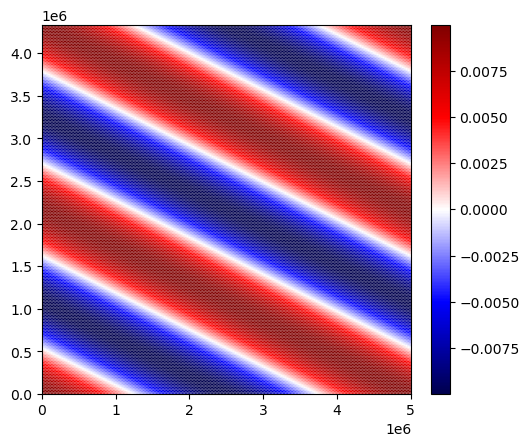

wallclock [12.579261383, 12.591102118]
error 0.05285548545241736
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_10/resolution_256x256/nvlevels_100/2022-09-07T14:44:17.658.txt


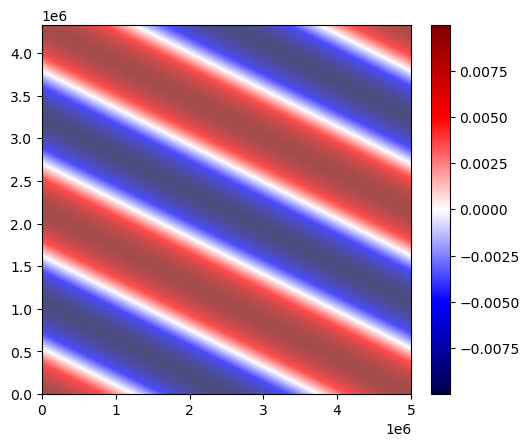

calculating error
wallclock [58.240570466, 57.753197177]
error 0.05372783193969387
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_10/resolution_512x512/nvlevels_100/2022-09-07T14:46:20.753.txt
calculating error
wallclock [243.413986388, 246.80618255]
error 0.05394414641033389


In [4]:
for nCellsX in [128, 256, 512]
    wc, err = gpucpuperftest(nCellsX, 2, 10, "CPU", true, true)
    println("wallclock $wc")
    println("error $err")
end

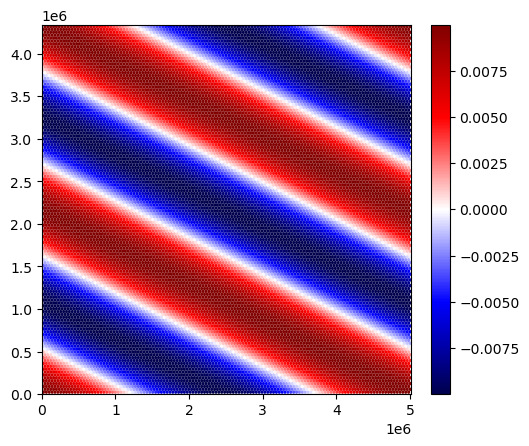

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_128x128/nvlevels_100/2022-09-07T15:00:02.400.txt


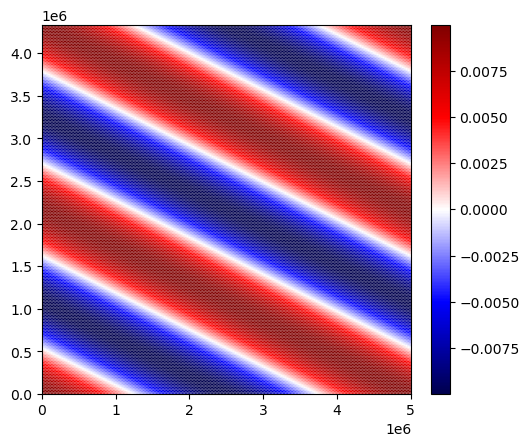

calculating error
wallclock [8.056696013, 6.4908e-5]
error 0.00036508535273453366
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_256x256/nvlevels_100/2022-09-07T15:00:14.277.txt


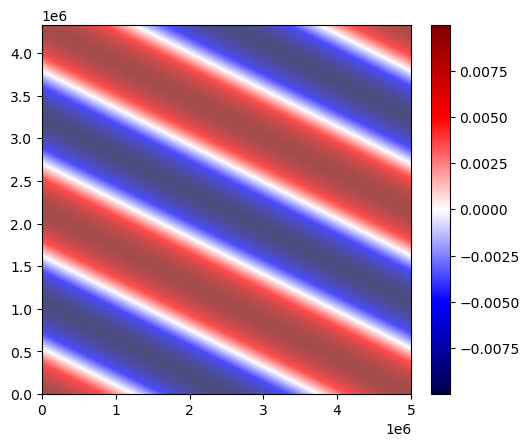

calculating error
wallclock [0.000102951, 6.0065e-5]
error 0.0001801138291574005
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_512x512/nvlevels_100/2022-09-07T15:00:21.951.txt
calculating error
wallclock [0.000101572, 6.5236e-5]
error 8.931275374904333e-5


In [5]:
for nCellsX in [128, 256, 512]
    wc, err = gpucpuperftest(nCellsX, 2, 10, "GPU", true, true)
    println("wallclock $wc")
    println("error $err")
end

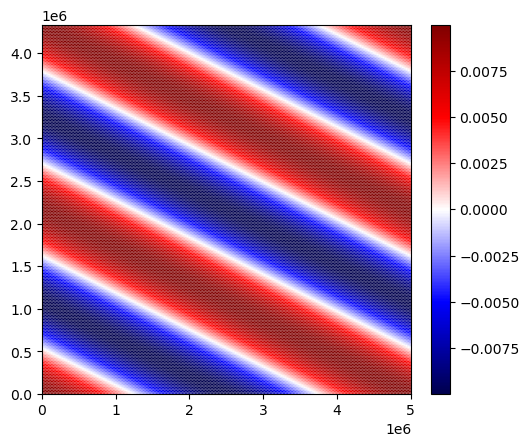

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_256x256/nvlevels_100/2022-09-07T15:16:11.173.txt
calculating error


0

In [11]:
nCellsX = 256
wc, err, mpasOceanCuda = gpucpuperftest(nCellsX, 2, 10, "GPU", true, true)
mpasOcean = MPAS_Ocean(CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
        "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", periodicity="NonPeriodic_x", nvlevels=100)
0

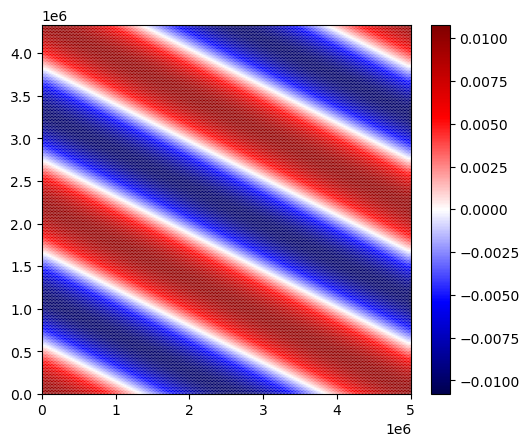

In [13]:
fig, ax, _ = heatMapMesh(mpasOcean, Array(mpasOceanCuda.sshCurrent))
display(fig)

the data copying step is actually 2 - 5 times slower than it is on the CPU! Memory is the bottleneck of the GPU